In [ ]:
Chatgpt Link: https://chatgpt.com/share/67adc4cc-33e0-8007-81ce-87a696aad60b

In [ ]:
#1. Automatic Threshold Selection for Canny Edge Detection 
    #• Implement automatic threshold selection using Otsu’s method. 
    #• Compute Otsu’s thresholding and apply it to Canny. 
    #• Compare results with manually chosen thresholds. Test on images with varying contrast.

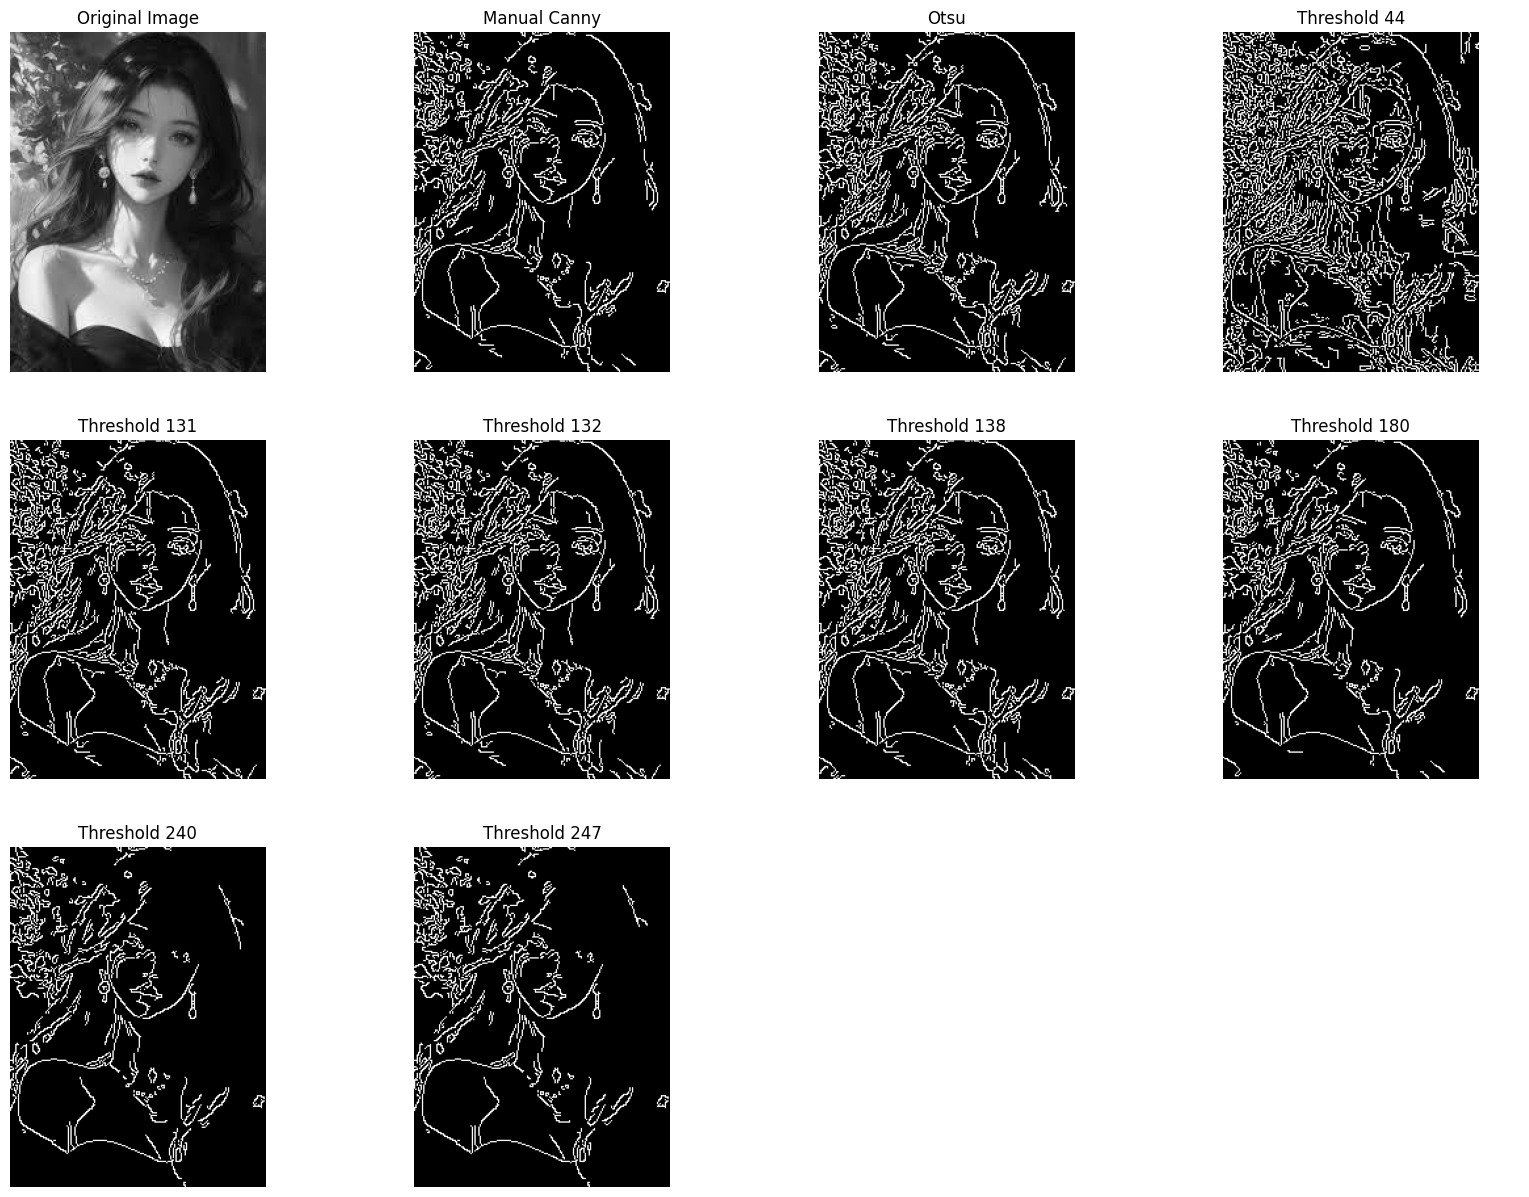


Comparison Metrics:
Otsu: SSIM = 0.8640, Edge Strength = 0.1212, Edge Sharpness = 92743.5059, Edge Density = 0.1365
Threshold 44: SSIM = 0.5331, Edge Strength = 0.2878, Edge Sharpness = 154948.8901, Edge Density = 0.2190
Threshold 131: SSIM = 0.8747, Edge Strength = 0.1212, Edge Sharpness = 90750.4624, Edge Density = 0.1340
Threshold 132: SSIM = 0.8830, Edge Strength = 0.1212, Edge Sharpness = 89259.5417, Edge Density = 0.1319
Threshold 138: SSIM = 0.8951, Edge Strength = 0.1212, Edge Sharpness = 87292.2474, Edge Density = 0.1296
Threshold 180: SSIM = 0.9729, Edge Strength = 0.1212, Edge Sharpness = 72301.9278, Edge Density = 0.1093
Threshold 240: SSIM = 0.8134, Edge Strength = 0.0000, Edge Sharpness = 52766.7474, Edge Density = 0.0804
Threshold 247: SSIM = 0.8072, Edge Strength = 0.0000, Edge Sharpness = 51857.7751, Edge Density = 0.0792


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import random

def manual_canny(image, low_thresh, high_thresh):
    edges = cv2.Canny(image, low_thresh, high_thresh)
    return edges

def otsu_canny(image):
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    otsu_thresh, _ = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.Canny(image, int(otsu_thresh * 0.5), int(otsu_thresh))
    return edges, otsu_thresh

def random_threshold_canny(image, num_thresholds=5):
    min_val, max_val = np.min(image), np.max(image)
    thresholds = sorted(random.sample(range(min_val, max_val), num_thresholds))
    edges_list = [cv2.Canny(image, int(t * 0.5), int(t)) for t in thresholds]
    return edges_list, thresholds

def compare_edges(original, manual, auto_methods, method_names):
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs[0, 0].imshow(original, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 1].imshow(manual, cmap='gray')
    axs[0, 1].set_title("Manual Canny")
    
    for i, (edges, name) in enumerate(zip(auto_methods, method_names)):
        row, col = divmod(i + 2, 4)
        axs[row, col].imshow(edges, cmap='gray')
        axs[row, col].set_title(name)
    
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

def edge_metrics(reference, edge_results, method_names):
    print("\nComparison Metrics:")
    for edges, name in zip(edge_results, method_names):
        ssim_index = ssim(reference, edges, data_range=edges.max() - edges.min())
        edge_strength = np.mean(cv2.Sobel(edges, cv2.CV_64F, 1, 1, ksize=5))
        laplacian_var = cv2.Laplacian(edges, cv2.CV_64F).var()
        edge_density = np.count_nonzero(edges) / edges.size
        print(f"{name}: SSIM = {ssim_index:.4f}, Edge Strength = {edge_strength:.4f}, Edge Sharpness = {laplacian_var:.4f}, Edge Density = {edge_density:.4f}")

# Load grayscale image
image = cv2.imread('/home/student/Downloads/girl.jpeg', cv2.IMREAD_GRAYSCALE)

# Apply manual thresholding with a random threshold
manual_low, manual_high = random.randint(50, 150), random.randint(151, 250)
manual_edges = manual_canny(image, manual_low, manual_high)

# Apply Otsu's method
otsu_edges, otsu_thresh = otsu_canny(image)

# Apply random thresholding within intensity range
random_edges, thresholds = random_threshold_canny(image, num_thresholds=7)

# Compare results
method_names = [f"Threshold {int(t)}" for t in thresholds]
compare_edges(image, manual_edges, [otsu_edges] + random_edges, ["Otsu"] + method_names)

# Compute and display comparison metrics
edge_metrics(manual_edges, [otsu_edges] + random_edges, ["Otsu"] + method_names)


In [ ]:
#Q2.Implement region-growing segmentation by selecting a seed point and expanding based on similarity criteria. 
   #Modify region growing to automatically select multiple seeds based on edge detection.

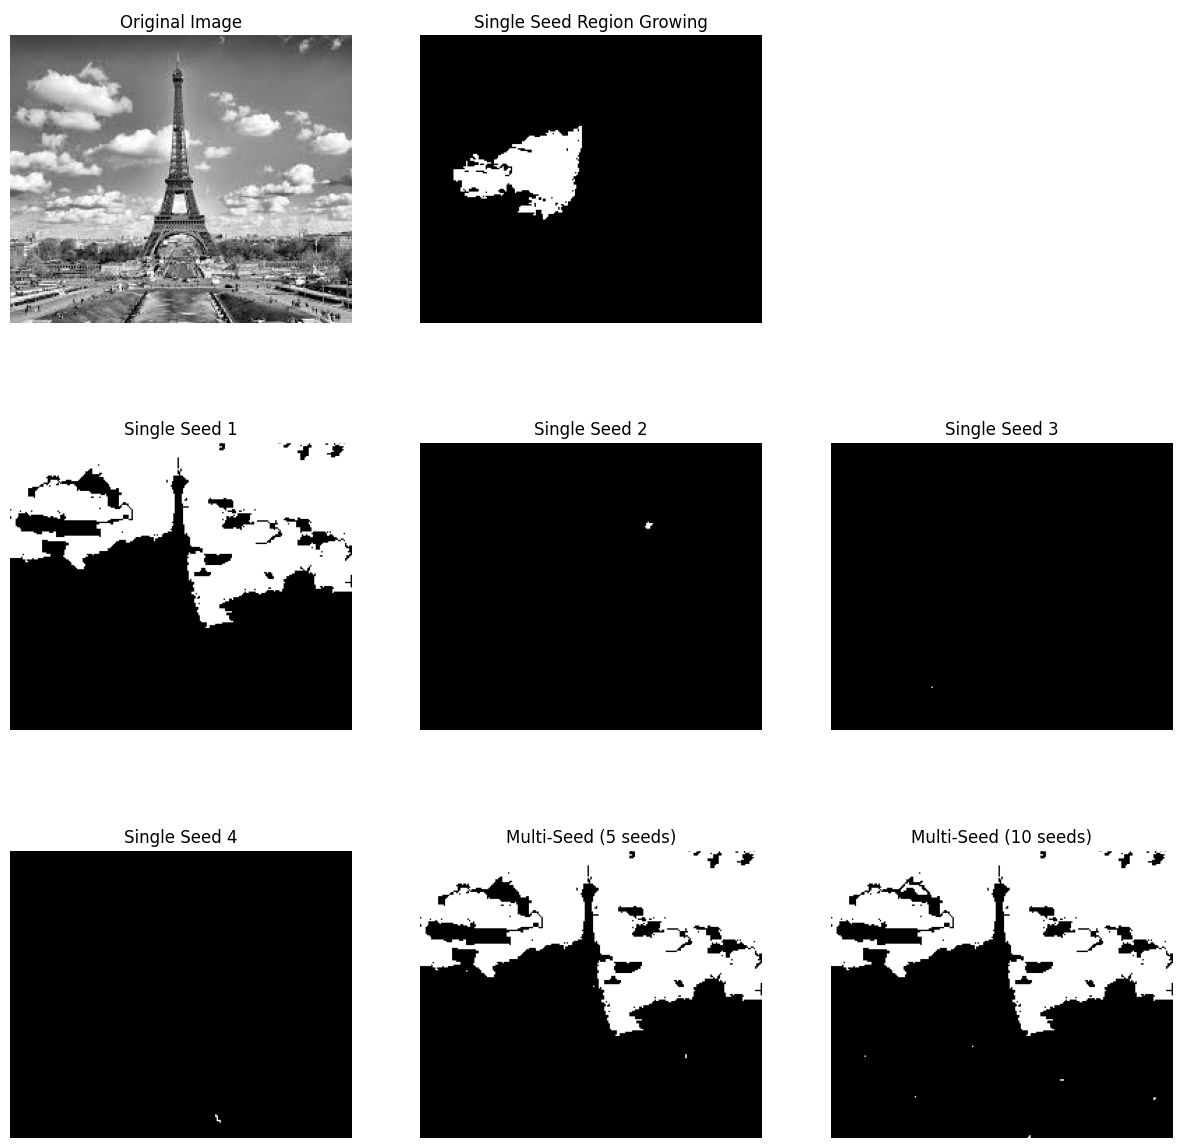

In [14]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def region_growing(image, seed, threshold=10):
    h, w = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    seed_list = [seed]
    visited = set()
    
    while seed_list:
        x, y = seed_list.pop(0)
        if (x, y) in visited:
            continue
        visited.add((x, y))
        segmented[x, y] = 255  # Mark as segmented
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < h and 0 <= ny < w and (nx, ny) not in visited:
                if abs(int(image[nx, ny]) - int(image[x, y])) < threshold:
                    seed_list.append((nx, ny))
    
    return segmented

def get_random_seeds(image, num_seeds=5):
    h, w = image.shape
    seeds = [(random.randint(0, h-1), random.randint(0, w-1)) for _ in range(num_seeds)]
    return seeds

def region_growing_multiple(image, seeds, threshold=10):
    segmented = np.zeros_like(image, dtype=np.uint8)
    for seed in seeds:
        segmented = cv2.bitwise_or(segmented, region_growing(image, seed, threshold))
    return segmented

# Load image in grayscale
image = cv2.imread('/home/student/Downloads/paris.jpeg', cv2.IMREAD_GRAYSCALE)

# Single seed region growing
single_seed = get_random_seeds(image, 1)[0]
single_seg = region_growing(image, single_seed)

# Multiple single-seed segmentations
multiple_single_segs = [region_growing(image, seed) for seed in get_random_seeds(image, 5)]

# Multi-seed region growing (5 and 10 seeds)
multi_seed_5 = region_growing_multiple(image, get_random_seeds(image, 5))
multi_seed_10 = region_growing_multiple(image, get_random_seeds(image, 10))

# Display results
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 1].imshow(single_seg, cmap='gray')
axs[0, 1].set_title("Single Seed Region Growing")

for i, seg in enumerate(multiple_single_segs):
    axs[(i//3) + 1, i % 3].imshow(seg, cmap='gray')
    axs[(i//3) + 1, i % 3].set_title(f"Single Seed {i+1}")

axs[2, 1].imshow(multi_seed_5, cmap='gray')
axs[2, 1].set_title("Multi-Seed (5 seeds)")
axs[2, 2].imshow(multi_seed_10, cmap='gray')
axs[2, 2].set_title("Multi-Seed (10 seeds)")

for ax in axs.flat:
    ax.axis('off')
plt.show()


In [ ]:
#Q3.Implement a quadtree-based region split and merge method for segmenting an image. 
   #Modify region splitting based on texture features (entropy, variance, Laplacian) instead of pixel intensity alone.

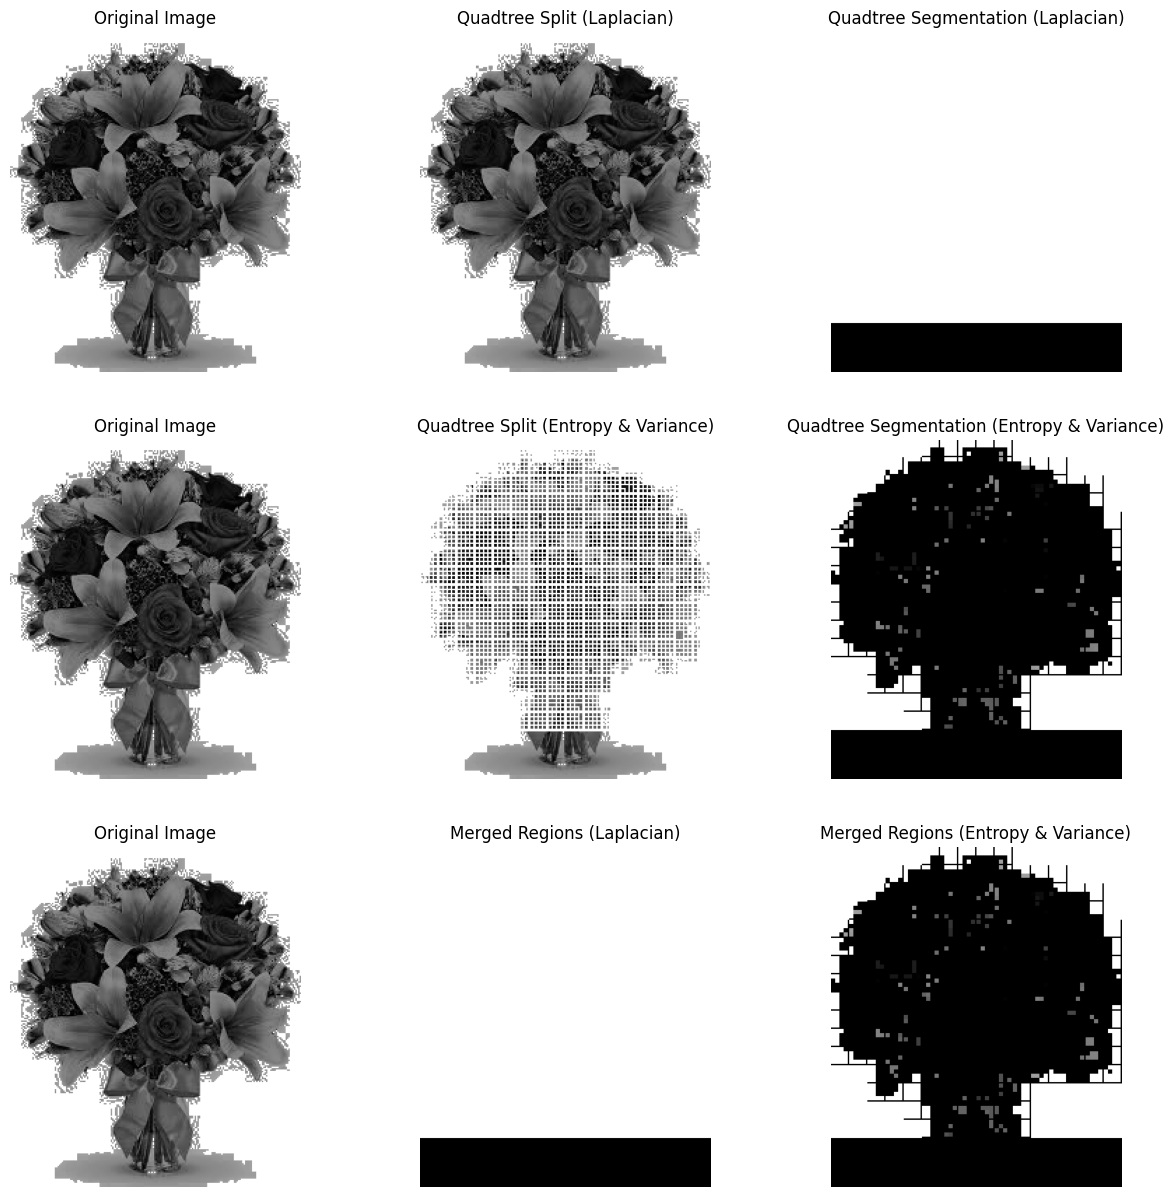

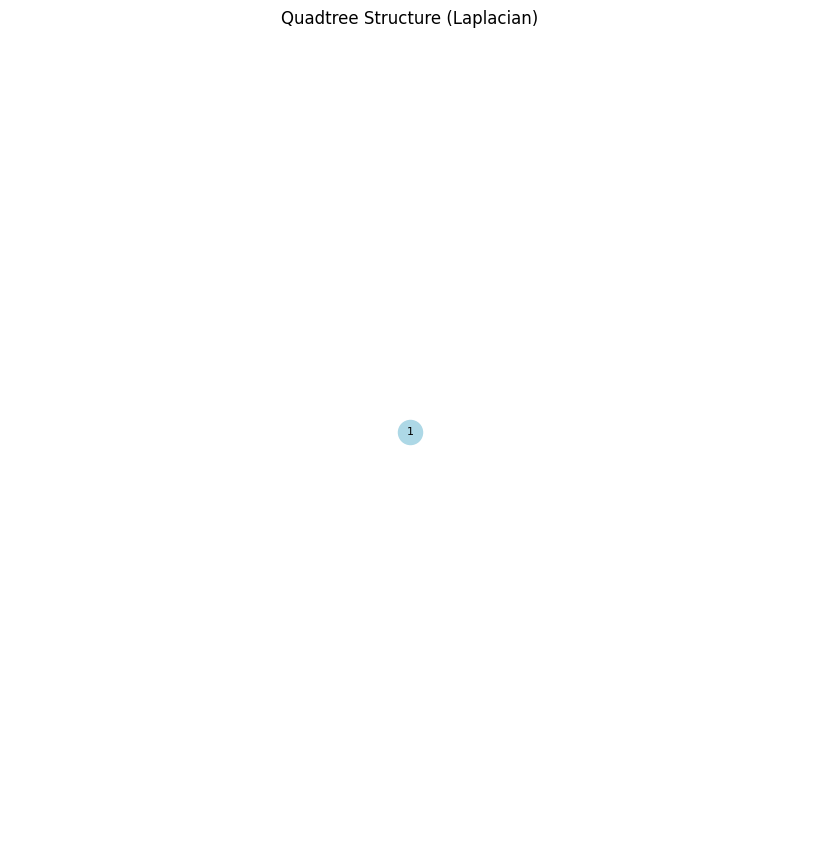

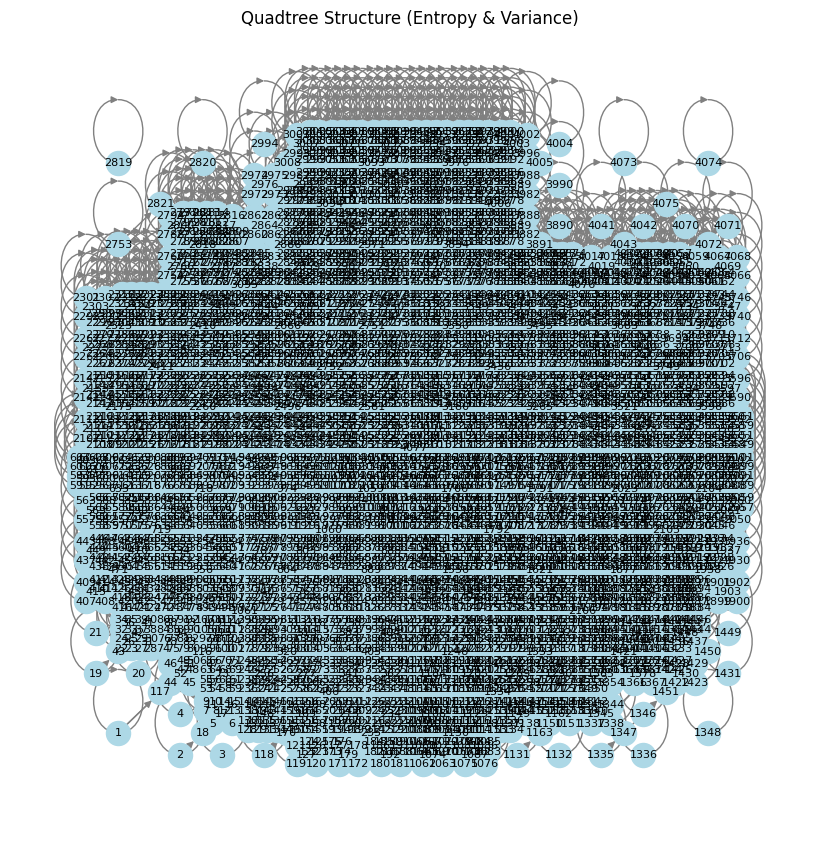

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.filters import laplace
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from scipy.ndimage import variance

def split_merge(image, threshold, method="laplacian"):
    h, w = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    region_map = np.zeros((h, w), dtype=int)
    split_visualization = image.copy()
    region_id = 1
    regions = {}
    quadtree_graph = nx.DiGraph()  # Initialize Graph for Quadtree

    def split(x, y, size, parent=None):
        nonlocal region_id
        if size < 2:
            return

        region = image[y:y+size, x:x+size]

        if method == "laplacian":
            feature = np.mean(np.abs(laplace(region)))
        else:  # entropy & variance method
            feature = np.mean(entropy(img_as_ubyte(region), disk(3))) + variance(region)

        if feature > threshold:
            half = size // 2
            split(x, y, half, region_id)
            split(x + half, y, half, region_id)
            split(x, y + half, half, region_id)
            split(x + half, y + half, half, region_id)
            cv2.rectangle(split_visualization, (x, y), (x + size, y + size), (255, 0, 0), 1)  # Draw quadtree boundary
            quadtree_graph.add_node(region_id, pos=(x + size//2, y + size//2))  # Add split node
            if parent:
                quadtree_graph.add_edge(parent, region_id)  # Connect to parent
            region_id += 1
        else:
            segmented[y:y+size, x:x+size] = np.mean(region)
            region_map[y:y+size, x:x+size] = region_id
            regions[region_id] = np.mean(region)
            quadtree_graph.add_node(region_id, pos=(x + size//2, y + size//2))  # Leaf node
            if parent:
                quadtree_graph.add_edge(parent, region_id)  # Connect to parent
            region_id += 1

    split(0, 0, min(h, w))

    # Merge adjacent regions based on similarity
    def merge_regions():
        merged = segmented.copy()
        for i in range(1, region_id):
            for j in range(i + 1, region_id):
                if j in regions and i in regions:
                    diff = abs(regions[i] - regions[j])
                    if diff < threshold * 0.5:  # Merge similar regions
                        merged[region_map == j] = regions[i]
                        region_map[region_map == j] = i  # Update region labels
                        del regions[j]  # Remove merged region

        return merged

    merged_image = merge_regions()
    return segmented, merged_image, split_visualization, quadtree_graph

# Load image in grayscale
image = cv2.imread('/home/student/Downloads/bouquet.jpeg', cv2.IMREAD_GRAYSCALE)
image = cv2.equalizeHist(image)  # Normalize for better contrast

# Apply quadtree split-merge using Laplacian
seg_laplacian, merged_laplacian, split_vis_laplacian, quadtree_laplacian = split_merge(image, threshold=15, method="laplacian")

# Apply quadtree split-merge using Entropy & Variance
seg_entropy_var, merged_entropy_var, split_vis_entropy_var, quadtree_entropy_var = split_merge(image, threshold=10, method="entropy_variance")

# Function to draw Quadtree
def draw_quadtree(graph, title):
    pos = nx.get_node_attributes(graph, 'pos')
    plt.figure(figsize=(8, 8))
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color="lightblue", edge_color="gray", font_size=8)
    plt.title(title)
    plt.show()

# Display results
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 1].imshow(split_vis_laplacian, cmap='gray')
axs[0, 1].set_title("Quadtree Split (Laplacian)")
axs[0, 2].imshow(seg_laplacian, cmap='gray')
axs[0, 2].set_title("Quadtree Segmentation (Laplacian)")

axs[1, 0].imshow(image, cmap='gray')
axs[1, 0].set_title("Original Image")
axs[1, 1].imshow(split_vis_entropy_var, cmap='gray')
axs[1, 1].set_title("Quadtree Split (Entropy & Variance)")
axs[1, 2].imshow(seg_entropy_var, cmap='gray')
axs[1, 2].set_title("Quadtree Segmentation (Entropy & Variance)")

axs[2, 0].imshow(image, cmap='gray')
axs[2, 0].set_title("Original Image")
axs[2, 1].imshow(merged_laplacian, cmap='gray')
axs[2, 1].set_title("Merged Regions (Laplacian)")
axs[2, 2].imshow(merged_entropy_var, cmap='gray')
axs[2, 2].set_title("Merged Regions (Entropy & Variance)")

for ax in axs.flat:
    ax.axis('off')

plt.show()

# Draw Quadtree Structures
draw_quadtree(quadtree_laplacian, "Quadtree Structure (Laplacian)")
draw_quadtree(quadtree_entropy_var, "Quadtree Structure (Entropy & Variance)")
